In [8]:
%load_ext autoreload
%autoreload 2

In [30]:
from utils import *

In [42]:
img_ex_1_train_path = "tf_img/ex_1/train"
img_ex_1_traj_path = "tf_img/ex_1/traj"

img_ex_2_train_path = "tf_img/ex_2/train"
img_ex_2_traj_path = "tf_img/ex_2/traj"

### Задача

Исследование многокомнатного помещения сенсором ограниченного обзора за минимальное число шагов


### Эксперимент № 1: Базовая имплементация

- Env: Dungeon
- Награда за шаг: процент исследованных клеток на данном шаге / общее кол-во клеток

Необходимо оценить качество текущей реализации и установить потенциально слабые места. Будем отслеживать величины, как отвечающие за тренировку, так и описывающие единичную траекторию (в момент, когда мы генерируем траекторию в режиме no_grad для gif-изображения).

Тренировка:
- Средняя длина эпизода
- Средняя награда за эпизод
- Номер итерации, с которой обучение выходит на плато

Единичая траектория:
- Процент исследованных клеток
- Процент неправильных действий (moved)
- Среднее кол-во исследованных клеток за шаг

Параметры запуска:

```
python ppo_train.py \
--seed 666 \
--n_iter 500 \
--env Dungeon \
--agent_ckpt_dir ./tmp/ppo/dungeon \
--train_gif_dir ./save/train/gifs \
--ray_result_dir ./save/train/ray_results
```

#### Train

Из графиков видно следующее:
    
- график максимальной награды за эпизод говорит о том, что большую часть итераций агент исследует среду максимум на 0.995. Имеется 2 подъема максимальной награды до 0.998. То есть, агент за время обучения ни разу не исследовал помещение полностью.

- средняя длина эпизода и средняя награда за эпизод не сошлись ни к каким предельным значениям

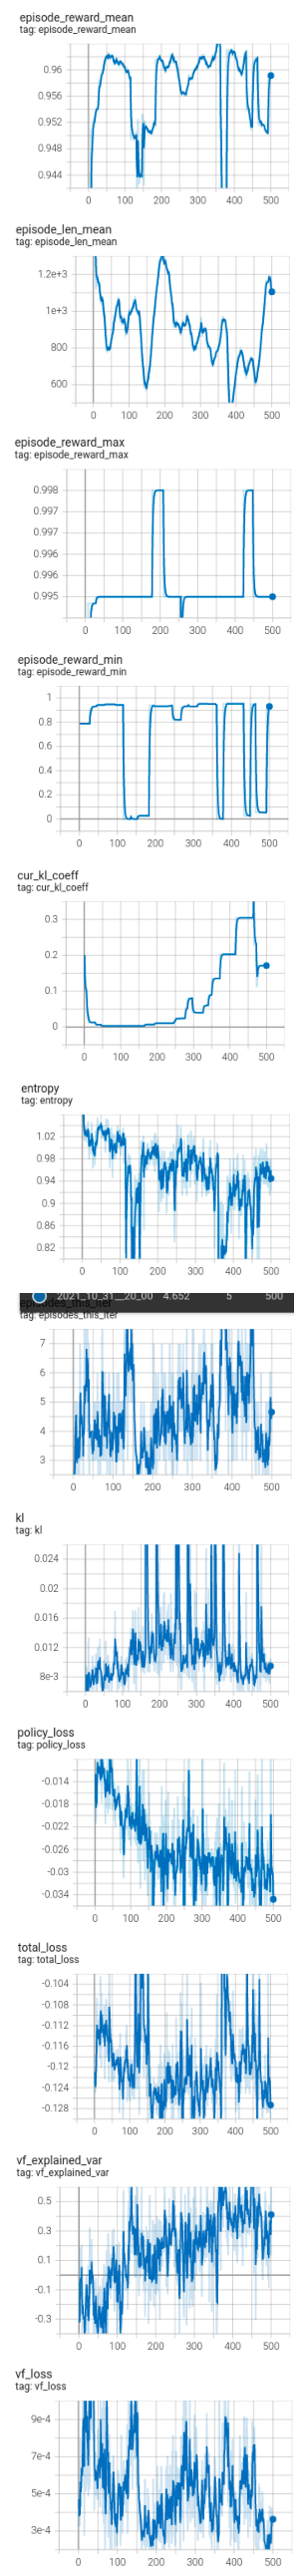

In [43]:
show_pictures(img_ex_1_train_path)

#### Trajectories

Траектория семплится после каждой 5-ой итерации обучения. 

Посмотрим на показатели траектории на последней итерации (500-ая)

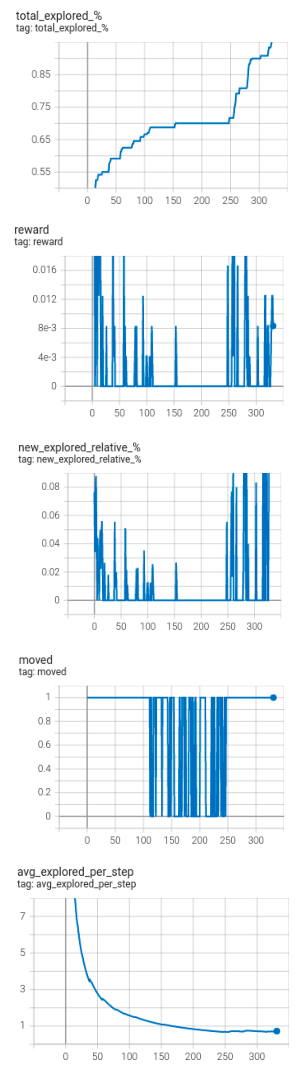

In [44]:
show_pictures(img_ex_1_traj_path)

### Эксперимент № 2

Попробуем улучшить награду. Данная среда с некоторыми оговорками схожа с задачей с лекции: можно представить, что объект занимает не одну клетку, а все поле видимости. Тогда метрика repetiotion rate может считаться как отношение просмотренных несколько раз клеток ко всем клеткам. 

Попробуем применить награду из примера с лекции: 

- добавлять кол-во всех просмотренных клеток к награде
- штрафофвать за столкновение (в нашем случае - только со стенами)
- штрафовать за действие без результата

```
if explored > 0:
    reward = 0.1 + 20*(self._map._total_explored - explored)/self._map._visible_cells
    if done:
        reward *= 2
else:
    reward = -0.5

if not moved:
    reward = -1
```

Параметры запуска:

```
python ppo_train.py \
--seed 666 \
--n_iter 500 \
--env ModifiedDungeon \
--agent_ckpt_dir ./tmp/ppo/modified_dungeon \
--train_gif_dir ./save/train/modified/gifs \
--ray_result_dir ./save/train/modified/ray_results
```

#### Графики обучения до 100 итерации

Видно, что уже между 40-ой и 50-ой итерацией, средняя длина траектории менее 300, то есть агент решает среду за 300 шагов. В то время как в 1-ом эксперименте, средняя длина траектории за все 500 итераций обучения только 1 раз опустилась чуть-чуть ниже 500 шагов

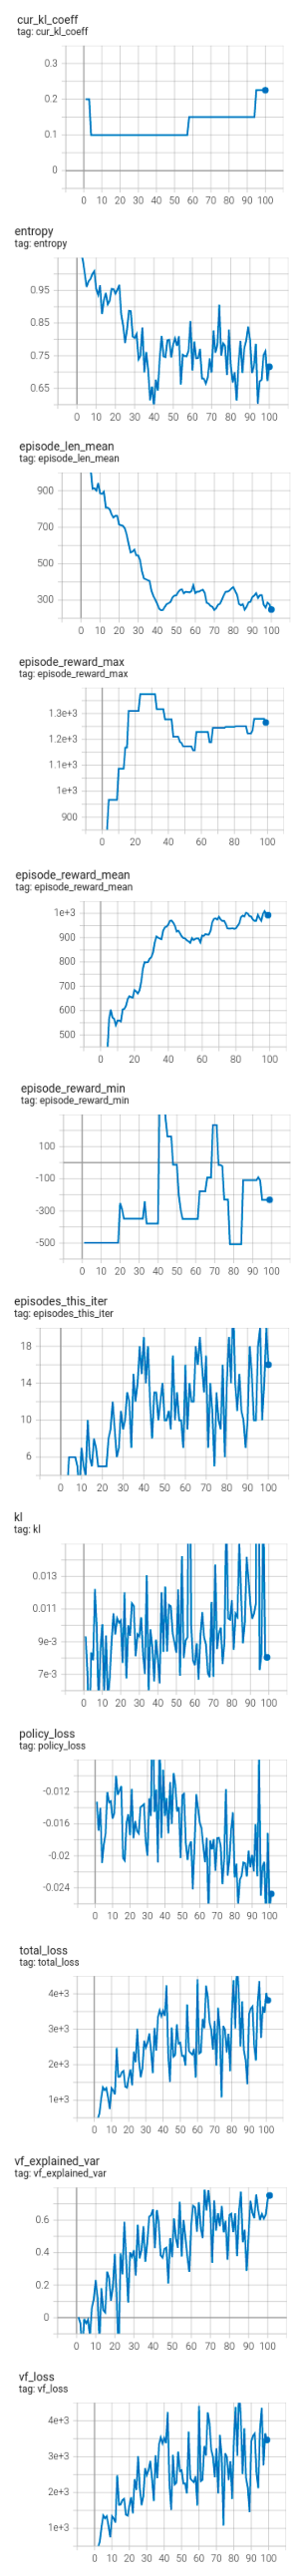

In [45]:
show_pictures(img_ex_2_train_path)

#### Траектория на 100-ой итерации

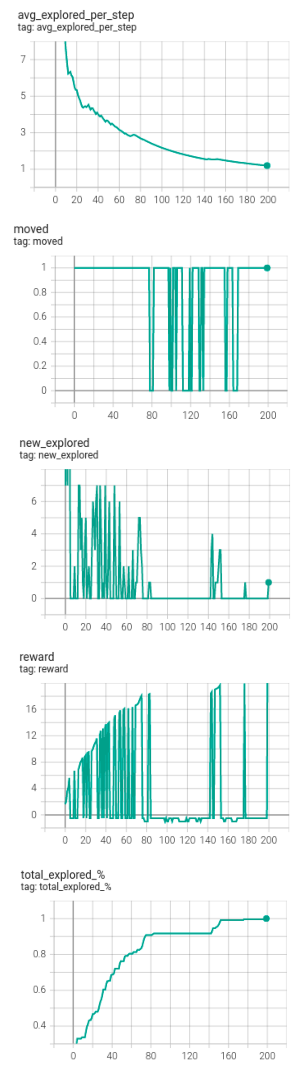

In [46]:
show_pictures(img_ex_2_traj_path)

### Идеи для улучшения

Одной из проблем является то, что агент не доходит до конца карты и идет в другую сторону. В конце эпизода остаются разреженные маленькие участки непросмотренных областей, разбросанные по карте. Этовлечет следующие трудности:

- Агенту тяжело их найти из-за маленького их размера
- Даже если агенту в какой-то момент точно сообщить их месторасположение, потребуется длинная траектория, чтобы покрыть их все.

В формировать награду на основе 2х показателей:

- кол-во областей связности непросмотренных клеток: чем их больше, тем хуже
- размер областей связности: чем он меньше, тем хуже

Ключевая идея в том, чтобы заставить агента равномерно и последовательно покрывать клетки карты.